## Detroit Census Appeal Work
### Finding correlations between datasets in Detroit
- created: 11-22-21 by GTP
- updated: 2-8-22 by GTP
- notes: we want to find correlations between census data, steve's survey, voter registration data, etc
- see https://docs.google.com/document/d/1sp19lFNQ63NEvL43jJZsgzTasI31M6Fnw7XSgrcG9h0/edit for additional notes
- see https://drive.google.com/drive/folders/1UZmf4j9Pi7P7K_R3NMBjPMTzRbUNM-rV for data

In [1]:
#import data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numbers
import decimal
#import data science packages
import scipy
import scipy.stats as stats

np.random.seed(222)
%matplotlib inline

In [2]:
#import geographic analysis libraries
import geopandas as gpd
from geopandas import GeoDataFrame
import shapely as shp
from shapely.geometry import Point
from shapely.geometry import shape
import os
import re
from fiona.crs import from_epsg
import pysal as ps

In [3]:
#import machine learning / regression libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [4]:
#set crs for entire analysis
crs = {'init': 'epsg:4326'}

In [5]:
rf_param_grid = {'max_depth': [10, 20, 30], 'n_estimators': np.arange(401,602,100)}

In [6]:
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100

## Read in Data

### Survey Done in 2020
- door knocking done by the city

In [7]:
survey_df = pd.read_csv('../data/All Doors FINAL Redacted 11-1-21.csv')

/Users/geoffperrin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1,3,4,5,6,7,8,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
len(survey_df[survey_df['TRACTCE10'].isna()])

19106

In [9]:
len(survey_df[survey_df['TRACTCE10'].isna()])/len(survey_df)

0.057172610052636144

In [10]:
def convert_tractce(tract_number):
    try:
        return str(int(tract_number))
    except:
        return "tract number n/a"

In [11]:
survey_df['TRACTCE10'] = survey_df['TRACTCE10'].apply(convert_tractce)

In [12]:
def get_survey_tract(census_tract):
    try:
        return str(int(census_tract))
    except:
        return ""

In [13]:
def get_census_tract(census_tract_og):
    x = str(census_tract_og)
    return x[-6:-2]

In [14]:
survey_df['tract'] = survey_df['CENSUS TRACT'].apply(get_survey_tract)

In [15]:
### filter out missing tracts
survey_df = survey_df[survey_df['tract']!=""]

In [16]:
len(survey_df)

315075

In [17]:
survey_df['vacant_dummy'] = survey_df['Occupancy Status:'].apply(lambda x: 1 if x == "vacant" else 0)
survey_df['occupied_dummy'] = survey_df['Occupancy Status:'].apply(lambda x: 1 if x == "occupied" else 0)

In [18]:
survey_df_by_census = survey_df.groupby(['tract'], as_index=False)['vacant_dummy', 'occupied_dummy'].mean()

<ipython-input-18-6dfe7bbbd5cd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  survey_df_by_census = survey_df.groupby(['tract'], as_index=False)['vacant_dummy', 'occupied_dummy'].mean()


In [19]:
survey_df_count_by_ct = survey_df.groupby(['tract'], as_index=False)['addr_id'].count()

In [20]:
survey_df_count_by_ct.columns = ['tract', 'survey_count']

### Census response rate

In [21]:
census_response_df = pd.read_csv('../data/2020 Census Response Rate by Tract (2).xlsx - decennialrr2020 (1).csv')

In [22]:
census_response_df.head(5)

,Tract,Internet Self Response,Total Self Response
0,500100,37.5,61.6
1,500200,38.9,66.6
2,500300,26.7,42.4
3,500400,11.2,20.4
4,500500,23.3,38.1


In [23]:
census_response_df['tract'] = census_response_df['Tract'].apply(lambda x: str(x)[0:4])

In [24]:
census_response_df.head()

,Tract,Internet Self Response,Total Self Response,tract
0,500100,37.5,61.6,5001
1,500200,38.9,66.6,5002
2,500300,26.7,42.4,5003
3,500400,11.2,20.4,5004
4,500500,23.3,38.1,5005


In [25]:
census_response_df = census_response_df[['tract', 'Internet Self Response', 'Total Self Response']]
census_response_df.columns = ['tract', 'internet_response_census', 'total_self_response_census']

## Vax status
- these census numbers are from 2019 ACS - Steve will give updated data that is 2020 census
- these are using CT10s - I would love to see something that has CT20s

In [26]:
vax_nov2021_df = pd.read_excel('../data/Vaccine Coverage by Census Tract as of 11.30.2021.xlsx')

In [27]:
vax_nov2021_df['tract'] = vax_nov2021_df['Census Tract'].apply(get_census_tract)

In [28]:
vax_nov2021_df_small = vax_nov2021_df[['tract', 'SVI', '% Received 1 or More Dose (Ages: 16+)', '% Fully Vaccinated (Ages: 16+)',\
                                       '% Received 1 or More Dose (Ages:5+)', '% Fully Vaccinated (Ages:5+)']]

In [29]:
vax_nov2021_df_small.columns = ['tract', 'SVI', 'pct_1_or_more_dose_16', 'pct_full_vaxed_16', 'pct_1_or_more_dose_5', 'pct_full_faxed_5']

## Voter Files
- need to merge on census tract to this...?

In [30]:
def get_census_tract_from_block(census_tract_og):
    x = str(census_tract_og)
    return x[0:4]

In [31]:
voter_nov_2020_df = pd.read_excel('../data/November 2020 General List of Voters.xlsx')

In [32]:
voter_nov_2020_gdf = gpd.read_file('../data/Voter Data/Nov20.shp')

In [33]:
voter_nov_2020_gdf['tract'] = voter_nov_2020_gdf['TRACTCE20'].apply(get_census_tract)

In [34]:
voters_by_tract = voter_nov_2020_gdf.groupby(['tract'], as_index=False)['Join_Count'].count()

In [35]:
voters_by_tract.columns = ['tract', 'voters_in_nov2020']

## Census Data
- I want to look at population / income / % black...?
- source: https://data.census.gov/cedsci/

### Population 2010
- source: https://data.census.gov/cedsci/all?g=0500000US26163%241400000&y=2010&d=DEC%20Summary%20File%201

In [36]:
pop_2010_df = pd.read_csv('../data/DECENNIALSF12010.P1_data_with_overlays_2021-12-05T220113.csv', skiprows=1)

In [37]:
pop_2010_df['tract'] = pop_2010_df['id'].apply(get_census_tract)

In [38]:
def clean_pop_total(x):
    pop_wout_parens = x.split('(')[0]
    return pop_wout_parens

In [39]:
pop_2010_df['Total'] = pop_2010_df['Total'].apply(clean_pop_total)

In [40]:
pop_2010_df_final = pop_2010_df[['tract', 'Total']]
pop_2010_df_final.columns = ['tract', 'tot_pop_2010']

In [41]:
pop_2010_df_final[pop_2010_df_final['tract']=='5430']

,tract,tot_pop_2010
259,5430,1814


### Income / Housing Units
- source: https://data.census.gov/cedsci/all?g=0500000US26163%241400000&y=2010&d=DEC%20Summary%20File%201
- table S1902

In [42]:
income_2019_df = pd.read_csv('../data/ACSST5Y2019.S1902_data_with_overlays_2021-12-05T222015.csv', skiprows=1)

In [43]:
income_2019_df = income_2019_df[['id', 'Estimate!!Number!!HOUSEHOLD INCOME!!All households', 'Estimate!!Mean income (dollars)!!HOUSEHOLD INCOME!!All households']]

In [44]:
income_2019_df['tract'] = income_2019_df['id'].apply(get_census_tract)

In [45]:
income_2019_df = income_2019_df[['tract', 'Estimate!!Number!!HOUSEHOLD INCOME!!All households', 'Estimate!!Mean income (dollars)!!HOUSEHOLD INCOME!!All households']]
income_2019_df.columns = ['tract', 'count_hh_2019', 'mean_hh_income_2019']

In [46]:
income_2019_df[income_2019_df['tract']=='5056']

,tract,count_hh_2019,mean_hh_income_2019


### Citizenship Status - 2019
- source: https://data.census.gov/cedsci/table?q=Citizenship&g=0500000US26163%241400000&y=2019&tid=ACSDT5Y2019.B05001&loc=42.2400,-83.1769,z10.0777
- table B05003
- needed for the denominator of # of people who voted in november 2020

In [47]:
citizen_2019_df = pd.read_csv('../data/ACSDT5Y2019.B05003_2022-01-25T195654/ACSDT5Y2019.B05003_data_with_overlays_2022-01-25T195636.csv', skiprows=1)

In [48]:
citizen_2019_df = citizen_2019_df[['Estimate!!Total:!!Male:!!18 years and over:',\
                                   'Estimate!!Total:!!Female:!!18 years and over:', \
                                   'Estimate!!Total:!!Male:!!18 years and over:!!Foreign born:!!Not a U.S. citizen', \
                                   'Estimate!!Total:!!Female:!!18 years and over:!!Foreign born:!!Not a U.S. citizen', 'id']]
citizen_2019_df.columns = ['male_pop_over18_2019', 'female_pop_over18_2019', 'male_pop_over18_nocitizen_2019', 'female_pop_over18_nocitizen_2019','id']

In [49]:
citizen_2019_df['over_18'] = citizen_2019_df['male_pop_over18_2019'] + citizen_2019_df['female_pop_over18_2019']
citizen_2019_df['citizen_over_18'] = citizen_2019_df['over_18'] - citizen_2019_df['male_pop_over18_nocitizen_2019'] - citizen_2019_df['female_pop_over18_nocitizen_2019']
citizen_2019_df['pct_citizen_over_18'] = citizen_2019_df['citizen_over_18'] / citizen_2019_df['over_18']

In [50]:
citizen_2019_df['tract'] = citizen_2019_df['id'].apply(get_census_tract)

In [51]:
citizen_2019_df_final = citizen_2019_df[['tract', 'citizen_over_18', 'pct_citizen_over_18']]

In [52]:
citizen_2019_df_final[citizen_2019_df_final['tract']=='5056']

,tract,citizen_over_18,pct_citizen_over_18


### population 2020 / % black / % white
- source: https://data.census.gov/cedsci/table?q=percent%20black&g=0500000US26163%241400000&y=2019&d=ACS%205-Year%20Estimates%20Data%20Profiles
- table DP05 - 2019 ACS

In [53]:
pop_df = pd.read_csv('../data/DECENNIALPL2020.P1_data_with_overlays_2021-12-08T181156.csv', skiprows=1)

In [54]:
pop_df = pop_df[['id', ' !!Total:', ' !!Total:!!Population of one race:!!White alone',\
                  ' !!Total:!!Population of one race:!!Black or African American alone']]

In [55]:
pop_df.columns = ['id', 'tot_pop_2020', 'tot_white', 'tot_black']

In [56]:
pop_df['pct_white'] = pop_df['tot_white'] / pop_df['tot_pop_2020']
pop_df['pct_black'] = pop_df['tot_black'] / pop_df['tot_pop_2020']

In [57]:
pop_df['tract'] = pop_df['id'].apply(get_census_tract)

In [58]:
pop_df_final = pop_df[['tract', 'tot_pop_2020', 'pct_white', 'pct_black']]

In [59]:
pop_df_final[pop_df_final['tract']=='5056']

,tract,tot_pop_2020,pct_white,pct_black
37,5056,4078,0.023786,0.928396


## Age 2019 ACS
- source: https://data.census.gov/cedsci/table?q=Age%20and%20Sex&t=Population%20Total%3APopulations%20and%20People&g=0500000US26163%241400000&tid=ACSST5Y2019.S0101
- table S0101
- I want to add <18 pop to analysis and >65 pop to analysis
- Incorporated <18 pop into regression, run regression - specifically i want to look at <18 pop to see CTC (child tax credit) outreach

In [60]:
age_df = pd.read_csv('../data/ACSST5Y2019.S0101_2022-02-08T213209/ACSST5Y2019.S0101_data_with_overlays_2022-02-08T213200.csv', skiprows=1)

In [61]:
age_df = age_df[['id', 'Estimate!!Total!!Total population', 'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years', \
                 'Estimate!!Percent!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years',\
                 'Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over',\
                  'Estimate!!Percent!!Total population!!SELECTED AGE CATEGORIES!!65 years and over']]
age_df.columns = ['id', 'pop_2019', 'pop_lt_18', 'pct_lt_18', 'pop_gt_65', 'pct_gt_65']
age_df['tract'] = age_df['id'].apply(get_census_tract)

In [62]:
age_df.head()

,id,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65,tract
0,1400000US26163500100,3369,776,23.0,269,8.0,5001
1,1400000US26163500200,2834,731,25.8,244,8.6,5002
2,1400000US26163500300,1900,483,25.4,59,3.1,5003
3,1400000US26163500400,1052,247,23.5,54,5.1,5004
4,1400000US26163500500,1289,286,22.2,97,7.5,5005


In [63]:
age_df_final = age_df[['tract', 'pop_2019', 'pop_lt_18', 'pct_lt_18', 'pop_gt_65', 'pct_gt_65']]

In [64]:
age_df_final[age_df_final['tract']=='5056']

,tract,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65


## merge together 2010 census files

In [65]:
tract_df_2010_total = vax_nov2021_df_small.merge(survey_df_by_census, how='left')
tract_df_2010_total = tract_df_2010_total.merge(income_2019_df, how='left')
tract_df_2010_total = tract_df_2010_total.merge(survey_df_count_by_ct, how='left')
tract_df_2010_total = tract_df_2010_total.merge(survey_df_by_census, how='left')
tract_df_2010_total = tract_df_2010_total.merge(citizen_2019_df_final, how='left')
tract_df_2010_total = tract_df_2010_total.merge(age_df_final, how='left')

In [66]:
### convert to numerics
tract_df_2010_total['mean_hh_income_2019'] = pd.to_numeric(tract_df_2010_total['mean_hh_income_2019'], errors='coerce')
tract_df_2010_total['mean_hh_income_2019'] = tract_df_2010_total['mean_hh_income_2019'].fillna(0)
tract_df_2010_total['pop_lt_18'] = pd.to_numeric(tract_df_2010_total['pop_lt_18'], errors='coerce')
tract_df_2010_total['pop_lt_18'] = tract_df_2010_total['pop_lt_18'].fillna(0)
tract_df_2010_total['pct_lt_18'] = pd.to_numeric(tract_df_2010_total['pct_lt_18'], errors='coerce')
tract_df_2010_total['pct_lt_18'] = tract_df_2010_total['pct_lt_18'].fillna(0)
tract_df_2010_total['pop_gt_65'] = pd.to_numeric(tract_df_2010_total['pop_gt_65'], errors='coerce')
tract_df_2010_total['pop_gt_65'] = tract_df_2010_total['pop_gt_65'].fillna(0)
tract_df_2010_total['pct_gt_65'] = pd.to_numeric(tract_df_2010_total['pct_gt_65'], errors='coerce')
tract_df_2010_total['pct_gt_65'] = tract_df_2010_total['pct_gt_65'].fillna(0)

In [67]:
### remove tracts 9852 and 9855 - these ones are outliers it seems, only pop counts of 0 and 3 exist for them
### 9852 is the tract on the eastside with the GM conner plant that is empty in the final map
### 9859 is the tract along russell on the SE corner of 75 and 94
### 9842 & 9836 are the 2 tracts that are railroad yards south of john kronk in SW detroit
tract_df_2010_total = tract_df_2010_total[~tract_df_2010_total['tract'].isin(['9850', '9852', '9855', '9859'])]

In [68]:
tract_df_2010_total['pct_full_vaxed_16'][tract_df_2010_total['pct_full_vaxed_16']=='>100%'] = 1
tract_df_2010_total['pct_1_or_more_dose_16'][tract_df_2010_total['pct_1_or_more_dose_16']=='>100%'] = 1
tract_df_2010_total['pct_1_or_more_dose_5'][tract_df_2010_total['pct_1_or_more_dose_5']=='>100%'] = 1
tract_df_2010_total['pct_full_faxed_5'][tract_df_2010_total['pct_full_faxed_5']=='>100%'] = 1

In [69]:
tract_df_2010_total.head()

,tract,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65
0,5001,0.5912,0.448,0.386,0.369,0.317,0.065629,0.897835,1438,49015.0,1478.0,2593,1.000000,3369,776,23.0,269,8.0
1,5002,0.4878,0.441,0.374,0.342,0.29,NaN,NaN,1088,61980.0,NaN,2094,0.995720,2834,731,25.8,244,8.6
2,5003,0.8413,0.411,0.346,0.324,0.272,0.323144,0.660480,811,50345.0,916.0,1417,1.000000,1900,483,25.4,59,3.1
3,5004,0.8786,0.294,0.248,0.23,0.193,1.000000,0.000000,375,34880.0,6.0,803,0.997516,1052,247,23.5,54,5.1
4,5005,0.6355,0.364,0.31,0.308,0.26,0.370460,0.607748,506,43058.0,826.0,998,0.995015,1289,286,22.2,97,7.5


In [70]:
tract_df_2010_total[tract_df_2010_total['tract']=='5104']

,tract,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65
59,5104,0.7346,0.499,0.424,0.468,0.397,0.457286,0.542714,260,30150.0,597.0,417,1.0,514,97,18.9,106,20.6


In [71]:
tract_df_2010_total[tract_df_2010_total['tract']=='5105']

,tract,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65
60,5105,0.9225,0.793,0.709,0.69,0.619,0.017744,0.968314,1164,39426.0,789.0,1707,0.536624,4257,1076,25.3,366,8.6


## Try to predict vacant % / occupied %
- 7% of tracts didn't have a number for some reason
- we need to fill in data where pct vacant is missing or zero.

Strategy:
- build a ML model to predict pct vacant based on SVI, count_hh_2019, mean_hh_income_2019, pct_full_vaxed_16: then take that model to then predict on original data

## Clean up data
- we've got some nans

In [72]:
len(tract_df_2010_total[tract_df_2010_total['vacant_dummy'].isna()]) / len(tract_df_2010_total)

0.06484641638225255

In [73]:
vacant_dummy_df = tract_df_2010_total[['SVI', 'count_hh_2019', 'mean_hh_income_2019', 'pct_full_vaxed_16', 'vacant_dummy']]

In [74]:
#drop rows where vacant_dummy is NaN
vacant_dummy_df = vacant_dummy_df[np.isfinite(vacant_dummy_df['vacant_dummy'])]

In [75]:
X = vacant_dummy_df.drop(['vacant_dummy'], axis=1)
y = vacant_dummy_df['vacant_dummy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [76]:
# use random forest to predict vacant_dummy
r_tree = RandomForestRegressor()
r_tree_tuned_vacant = GridSearchCV(r_tree, rf_param_grid)
r_tree_tuned_vacant.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': array([401, 501, 601])})

In [77]:
#explore feature importance
feature_importance = r_tree_tuned_vacant.best_estimator_.fit(X_train, y_train).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)
Feature_importance_df

,variables,importance
0,count_hh_2019,0.458565
1,SVI,0.232958
2,pct_full_vaxed_16,0.168908
3,mean_hh_income_2019,0.139569


In [78]:
#run accuracy metrics
predictions = r_tree_tuned_vacant.predict(X_test)
#RMSE
mean_squared_error(y_test, predictions)**0.5

0.16644810002286364

In [79]:
y_test.std()

0.16809712415082523

In [80]:
#apply model to full data
vacant_dummy_predict = tract_df_2010_total[['SVI', 'count_hh_2019', 'mean_hh_income_2019', 'pct_full_vaxed_16']]

tract_df_2010_total['vacant_dummy_predict'] = r_tree_tuned_vacant.predict(vacant_dummy_predict)

#if missing vacant_dummy (or if it's zero), replace with predicted value
tract_df_2010_total['vacant_dummy'][(np.isnan(tract_df_2010_total['vacant_dummy']))]\
= tract_df_2010_total['vacant_dummy_predict']
        
#drop predicted vacant_dummy_predict
tract_df_2010_total = tract_df_2010_total.drop(['vacant_dummy_predict'], axis=1)

<ipython-input-80-f819fbe4649f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_df_2010_total['vacant_dummy'][(np.isnan(tract_df_2010_total['vacant_dummy']))]\


In [81]:
### fill in blank occupied_dummies with 1 - predicted vacant dummy
tract_df_2010_total['occupied_dummy'][tract_df_2010_total['occupied_dummy'].isna()] = 1 - tract_df_2010_total['vacant_dummy']

<ipython-input-81-091f31794f36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_df_2010_total['occupied_dummy'][tract_df_2010_total['occupied_dummy'].isna()] = 1 - tract_df_2010_total['vacant_dummy']


## merge together 2020 census files

In [82]:
tract_df_2020_total = census_response_df.merge(pop_df_final, how='left')
tract_df_2020_total = tract_df_2020_total.merge(voters_by_tract, how='left')
tract_df_2020_total = tract_df_2020_total.merge(census_response_df, how='left')

In [83]:
tract_df_2020_total['tot_pop_2020'] = pd.to_numeric(tract_df_2020_total['tot_pop_2020'], errors='coerce')
tract_df_2020_total['tot_pop_2020'] = tract_df_2020_total['tot_pop_2020'].fillna(0)
tract_df_2020_total['voters_in_nov2020'] = tract_df_2020_total['voters_in_nov2020'].fillna(0)
tract_df_2020_total['pct_black'] = tract_df_2020_total['pct_black'].fillna(0)
tract_df_2020_total['pct_white'] = tract_df_2020_total['pct_white'].fillna(0)
tract_df_2020_total['internet_response_census'] = tract_df_2020_total['internet_response_census'].fillna(0)
tract_df_2020_total['total_self_response_census'] = tract_df_2020_total['total_self_response_census'].fillna(0)

In [84]:
tract_df_2020_total.sample(10)

,tract,internet_response_census,total_self_response_census,tot_pop_2020,pct_white,pct_black,voters_in_nov2020
105,5219,31.5,52.0,2943,0.339110,0.566429,1240
16,5017,26.5,47.8,2218,0.197475,0.744815,698
264,5471,33.5,55.9,4714,0.018880,0.938481,1804
133,5265,19.6,33.9,1796,0.039532,0.676503,616
153,5319,15.0,27.2,866,0.054273,0.870670,251
267,9851,30.4,32.3,154,0.409091,0.512987,42
25,5034,18.9,34.7,886,0.041761,0.856659,343
140,5308,15.2,31.3,1394,0.021521,0.930416,492
172,5350,27.5,50.7,2411,0.024056,0.914144,1003
254,5457,38.9,60.5,2925,0.346667,0.422906,723


## Need to merge 2010 census tracts to 2020 census tracts
### read in census tract shapefiles
- source: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html

In [85]:
ct_gdf = gpd.read_file('../data/tl_2020_26_tract20.shp')

In [86]:
ct_gdf['tract'] = ct_gdf['GEOID20'].apply(get_census_tract)

In [87]:
ct10_gdf = gpd.read_file('../data/tl_2020_26_tract10.shp')

In [88]:
ct10_gdf['tract'] = ct10_gdf['GEOID10'].apply(get_census_tract)

In [89]:
tract20_df_final_shp = ct_gdf.merge(tract_df_2020_total, how='left', on='tract')

In [90]:
tract20_df_final_shp.drop(columns=['STATEFP20', 'COUNTYFP20','TRACTCE20',\
                                 'GEOID20', 'NAME20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20',\
                                 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20'], inplace=True)

In [91]:
tract20_df_final_shp.to_file('../data/tract20_df_final_shp.shp')

In [92]:
tract10_df_final_shp = ct10_gdf.merge(tract_df_2010_total, how='left', on='tract')

In [93]:
tract10_df_final_shp.drop(columns=['STATEFP10', 'COUNTYFP10','TRACTCE10',\
                                 'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10',\
                                 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10'], inplace=True)

In [94]:
tract10_df_final_shp.to_file('../data/tract10_df_final_shp.shp')

## Merge 2010 and 2020 shapefiles together
1. spatially merge using overlay function (returns areas of intersection)
2. (in keep_polys_and_explode) - only keep polygons that have a significant area - explode converts multipolygons to polygons (https://stackoverflow.com/questions/68861184/convert-geopandas-multipolygon-to-polygon) and only keep polygons (not geometry collections)
3. aggregate accordingly (income take average, etc)

In [95]:
tract_20_w_10_gdf_merged = gpd.overlay(tract20_df_final_shp, tract10_df_final_shp, how='union', make_valid=False, keep_geom_type=False)

In [96]:
tract_20_w_10_gdf_merged.head()

,tract_1,internet_response_census,total_self_response_census,tot_pop_2020,pct_white,pct_black,voters_in_nov2020,tract_2,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,vacant_dummy,occupied_dummy,count_hh_2019,mean_hh_income_2019,survey_count,citizen_over_18,pct_citizen_over_18,pop_2019,pop_lt_18,pct_lt_18,pop_gt_65,pct_gt_65,geometry
0,5919,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-83.24385 42.08143, -83.24375 42.081..."
1,5930,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-83.21551 42.11191, -83.2161..."
2,9820,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-83.24167 42.10964, -83.2416..."
3,5944,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-83.21440 42.11194)
4,5991,NaN,NaN,NaN,NaN,NaN,NaN,5919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTILINESTRING ((-83.24185 42.09537, -83.2418..."


In [97]:
tract_20_w_10_gdf_merged['pct_full_vaxed_16'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_full_vaxed_16'], errors='coerce')
tract_20_w_10_gdf_merged['pct_1_or_more_dose_16'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_1_or_more_dose_16'], errors='coerce')
tract_20_w_10_gdf_merged['pct_1_or_more_dose_5'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_1_or_more_dose_5'], errors='coerce')
tract_20_w_10_gdf_merged['pct_full_faxed_5'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_full_faxed_5'], errors='coerce')
tract_20_w_10_gdf_merged['citizen_over_18'] = pd.to_numeric(tract_20_w_10_gdf_merged['citizen_over_18'], errors='coerce')
tract_20_w_10_gdf_merged['pop_2019'] = pd.to_numeric(tract_20_w_10_gdf_merged['pop_2019'], errors='coerce')
tract_20_w_10_gdf_merged['pop_lt_18'] = pd.to_numeric(tract_20_w_10_gdf_merged['pop_lt_18'], errors='coerce')
tract_20_w_10_gdf_merged['pct_lt_18'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_lt_18'], errors='coerce')
tract_20_w_10_gdf_merged['pop_gt_65'] = pd.to_numeric(tract_20_w_10_gdf_merged['pop_gt_65'], errors='coerce')
tract_20_w_10_gdf_merged['pct_gt_65'] = pd.to_numeric(tract_20_w_10_gdf_merged['pct_gt_65'], errors='coerce')

In [98]:
def keep_polys_and_explode(gdf_in):
    gdf_in_copy = gdf_in.copy()
    print(gdf_in_copy.crs)
    gdf_in_copy = gdf_in_copy.to_crs({'init': 'epsg:3857'})
    print(gdf_in_copy.crs)
    gdf_in_copy["area_km2"] = gdf_in_copy['geometry'].area/ 10**6
    ### remove polygons that are tiny intersections (<0.1km2)
    gdf_in_copy = gdf_in_copy[gdf_in_copy['area_km2']>0.1]
    exploded=gdf_in_copy.explode()
    exploded.reset_index(inplace=True)
    exploded['type'] = exploded['geometry'].apply(lambda x: str(type(x)))
    exploded = exploded[exploded['type']=="<class 'shapely.geometry.polygon.Polygon'>"]
    exploded.drop(['level_0', 'level_1', 'type'], axis=1, inplace=True)
    return exploded

In [99]:
tract_20_w_10_gdf_exploded = keep_polys_and_explode(tract_20_w_10_gdf_merged)

epsg:4269


/Users/geoffperrin/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


+init=epsg:3857 +type=crs


In [100]:
tract_20_w_10_gdf_mean = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['internet_response_census', 'total_self_response_census',
                                                                                                     'pct_white', 'pct_black', \
                                                                                                     'SVI', 'pct_1_or_more_dose_16', 'pct_full_vaxed_16',\
                                                                                                     'pct_1_or_more_dose_5', 'pct_full_faxed_5', 'voters_in_nov2020', 'tot_pop_2020', \
                                                                                   'vacant_dummy', 'occupied_dummy',\
                                                                                  'mean_hh_income_2019'].mean()

<ipython-input-100-da33dd75bcef>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tract_20_w_10_gdf_mean = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['internet_response_census', 'total_self_response_census',


In [101]:
tract_20_w_10_gdf_sum = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['count_hh_2019', 'survey_count', 'citizen_over_18', 'pop_2019',\
                                                                                       'pop_lt_18', 'pop_gt_65'].sum()

<ipython-input-101-556e5845be44>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tract_20_w_10_gdf_sum = tract_20_w_10_gdf_exploded.groupby(['tract_1'], as_index=False)['count_hh_2019', 'survey_count', 'citizen_over_18', 'pop_2019',\


In [102]:
tract_20_w_10_gdf_total_agg = tract_20_w_10_gdf_mean.merge(tract_20_w_10_gdf_sum)

In [103]:
tract_20_w_10_gdf_total_agg.rename(columns={"tract_1": "tract"}, inplace=True)

In [104]:
tract_20_w_10_gdf_shp = ct_gdf.merge(tract_20_w_10_gdf_total_agg, how='left', on='tract')

In [105]:
tract_20_w_10_gdf_shp.drop(columns=['STATEFP20', 'COUNTYFP20','TRACTCE20',\
                                 'GEOID20', 'NAME20', 'NAMELSAD20', 'MTFCC20', 'FUNCSTAT20',\
                                 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20'], inplace=True)

In [106]:
tract_20_w_10_gdf_shp_w_10_nans = tract_20_w_10_gdf_shp.merge(tract10_df_final_shp, how='left', suffixes=('', '_10'), on='tract')

In [107]:
tract_20_w_10_gdf_shp_w_10_nans[tract_20_w_10_gdf_shp_w_10_nans['tract']=='5091']

,geometry,tract,internet_response_census,total_self_response_census,pct_white,pct_black,SVI,pct_1_or_more_dose_16,pct_full_vaxed_16,pct_1_or_more_dose_5,pct_full_faxed_5,voters_in_nov2020,tot_pop_2020,vacant_dummy,occupied_dummy,mean_hh_income_2019,count_hh_2019,survey_count,citizen_over_18,pop_2019,pop_lt_18,pop_gt_65,geometry_10,SVI_10,pct_1_or_more_dose_16_10,pct_full_vaxed_16_10,pct_1_or_more_dose_5_10,pct_full_faxed_5_10,vacant_dummy_10,occupied_dummy_10,count_hh_2019_10,mean_hh_income_2019_10,survey_count_10,citizen_over_18_10,pct_citizen_over_18,pop_2019_10,pop_lt_18_10,pct_lt_18,pop_gt_65_10,pct_gt_65
4982,"POLYGON ((-83.08942 42.41816, -83.08858 42.418...",5091,26.4,40.7,0.128205,0.217839,0.82855,0.646,0.5665,0.579,0.508,1366.0,4563.0,0.237515,0.755514,34788.0,1424.0,1386.0,2124.0,4771.0,1173.0,472.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16_10']
tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16_10']
tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_5'][tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_5'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_5_10']
tract_20_w_10_gdf_shp_w_10_nans['pct_full_faxed_5'][tract_20_w_10_gdf_shp_w_10_nans['pct_full_faxed_5'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_full_faxed_5_10']
tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18'][tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18']==0] = tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18_10']
tract_20_w_10_gdf_shp_w_10_nans['vacant_dummy'][tract_20_w_10_gdf_shp_w_10_nans['vacant_dummy'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['vacant_dummy_10']
tract_20_w_10_gdf_shp_w_10_nans['occupied_dummy'][tract_20_w_10_gdf_shp_w_10_nans['occupied_dummy'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['occupied_dummy_10']
tract_20_w_10_gdf_shp_w_10_nans['mean_hh_income_2019'][tract_20_w_10_gdf_shp_w_10_nans['mean_hh_income_2019'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['mean_hh_income_2019_10']
tract_20_w_10_gdf_shp_w_10_nans['count_hh_2019'][tract_20_w_10_gdf_shp_w_10_nans['count_hh_2019']==0] = tract_20_w_10_gdf_shp_w_10_nans['count_hh_2019_10']
tract_20_w_10_gdf_shp_w_10_nans['survey_count'][tract_20_w_10_gdf_shp_w_10_nans['survey_count']==0] = tract_20_w_10_gdf_shp_w_10_nans['survey_count_10']
tract_20_w_10_gdf_shp_w_10_nans['pop_2019'][tract_20_w_10_gdf_shp_w_10_nans['pop_2019']==0] = tract_20_w_10_gdf_shp_w_10_nans['pop_2019']
tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18'][tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18']==0] = tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18']
tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65'][tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65']==0] = tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65']

<ipython-input-108-a2e77c8e47ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_1_or_more_dose_16_10']
<ipython-input-108-a2e77c8e47ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'][tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16'].isna()] = tract_20_w_10_gdf_shp_w_10_nans['pct_full_vaxed_16_10']
<ipython-input-108-a2e77c8e47ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [109]:
### pct voted
tract_20_w_10_gdf_shp_w_10_nans['pct_voted_nov2020'] = tract_20_w_10_gdf_shp_w_10_nans['voters_in_nov2020'] / tract_20_w_10_gdf_shp_w_10_nans['citizen_over_18']

In [110]:
tract_20_w_10_gdf_shp_w_10_nans['survey_count'] = tract_20_w_10_gdf_shp_w_10_nans['survey_count'].fillna(0)

In [111]:
tract_20_w_10_gdf_shp_w_10_nans['pct_lt_18'] = tract_20_w_10_gdf_shp_w_10_nans['pop_lt_18'] / tract_20_w_10_gdf_shp_w_10_nans['pop_2019']
tract_20_w_10_gdf_shp_w_10_nans['pct_gt_65'] = tract_20_w_10_gdf_shp_w_10_nans['pop_gt_65'] / tract_20_w_10_gdf_shp_w_10_nans['pop_2019']

In [112]:
tract_20_w_10_gdf_shp_w_10_nans.drop(['geometry_10', 
                                      'SVI_10', 'vacant_dummy_10', 'occupied_dummy_10',\
                                      'count_hh_2019_10', 'mean_hh_income_2019_10', 'survey_count_10',\
                                     'pct_citizen_over_18', 'citizen_over_18_10', 'pop_lt_18', 'pop_2019',\
                                     'pop_gt_65'], axis=1, inplace=True)

## Look at correlation matrix
- where did all of these come from...?

In [113]:
feature_list = ['tot_pop_2020',\
                     'SVI', 'pct_full_vaxed_16', 'pct_full_faxed_5',\
                     'vacant_dummy', 'occupied_dummy', 'count_hh_2019',\
                     'mean_hh_income_2019', 'internet_response_census', \
                     'total_self_response_census', 'survey_count', \
                'pct_white', 'pct_black', 'pct_voted_nov2020',\
               'citizen_over_18', 'pct_lt_18', 'pct_gt_65']

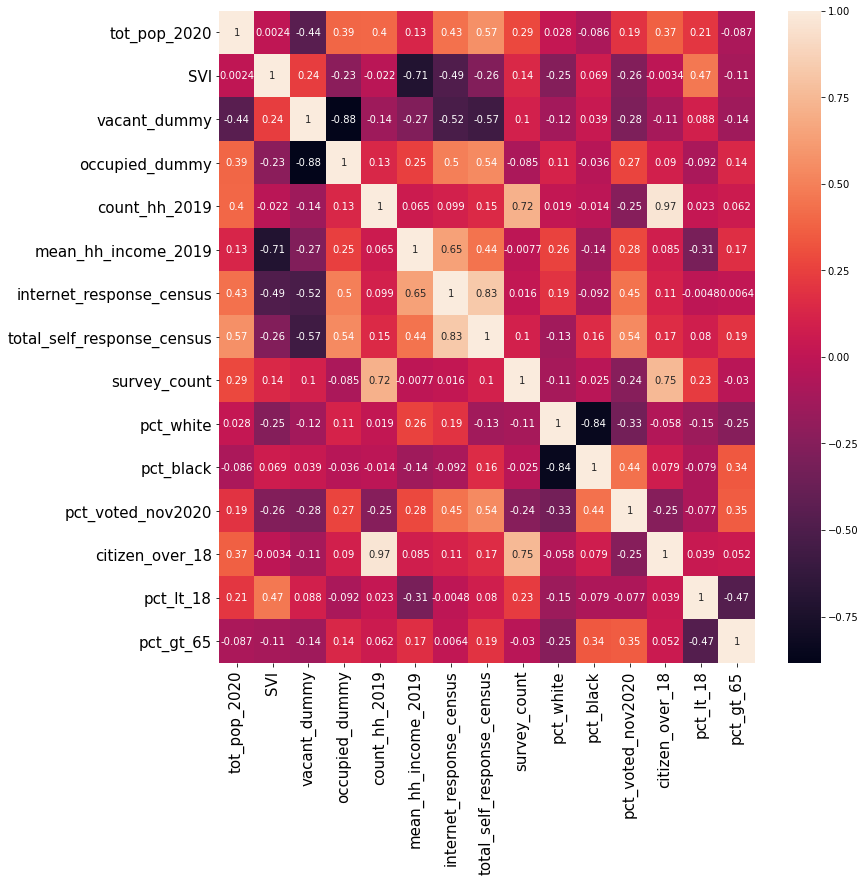

In [114]:
#output map
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


sns.heatmap(tract_20_w_10_gdf_shp_w_10_nans[feature_list].corr(), annot=True, ax=ax)

## "Civic Participation" Metric
- z(vax) + z(voter) + z(census) + z(pop)

In [115]:
### essentially, subset to just detroit CTs
tract_20_w_10_gdf_shp_detroit = tract_20_w_10_gdf_shp_w_10_nans[tract_20_w_10_gdf_shp_w_10_nans['pct_black']>=0]
### remove nas
tract_20_w_10_gdf_shp_detroit = tract_20_w_10_gdf_shp_detroit[~tract_20_w_10_gdf_shp_detroit['SVI'].isna()]

In [116]:
# now iterate over the remaining columns and create a new zscore column
zscore_cols = ['pct_full_faxed_5', 'pct_voted_nov2020', 'total_self_response_census', 'tot_pop_2020']
for col in zscore_cols:
    col_zscore = col + '_zscore'
    tract_20_w_10_gdf_shp_detroit[col_zscore] = \
    (tract_20_w_10_gdf_shp_detroit[col] - tract_20_w_10_gdf_shp_detroit[col].mean())/\
    tract_20_w_10_gdf_shp_detroit[col].std(ddof=0)

In [117]:
tract_20_w_10_gdf_shp_detroit_final = tract_20_w_10_gdf_shp_detroit[['geometry', 'tract', 'pct_full_faxed_5', 'pct_voted_nov2020', 'total_self_response_census', 'tot_pop_2020',\
                                                                    'pct_full_faxed_5_zscore', 'pct_voted_nov2020_zscore', 'total_self_response_census_zscore', 'tot_pop_2020_zscore']]

In [118]:
tract_20_w_10_gdf_shp_detroit_final.columns = ['geometry', 'tract', 'pct_vax5', 'pct_vote', 'pct_census', 'population', 'pct_vax5_z', 'pct_vote_z', 'pct_census_z', 'population_z']

In [119]:
tract_20_w_10_gdf_shp_detroit_final.to_file('../data/tract_20_w_10_gdf_shp_detroit.shp')

## Regression predicting civic participation vs income / pop density / % black
- education?

In [120]:
tract_20_w_10_gdf_shp_detroit_copy = tract_20_w_10_gdf_shp_detroit.copy()
print(tract_20_w_10_gdf_shp_detroit_copy.crs)
tract_20_w_10_gdf_shp_detroit_copy= tract_20_w_10_gdf_shp_detroit_copy.to_crs({'init': 'epsg:3857'})
print(tract_20_w_10_gdf_shp_detroit_copy.crs)

epsg:4269
+init=epsg:3857 +type=crs


/Users/geoffperrin/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [121]:
tract_20_w_10_gdf_shp_detroit_copy["area_km2"] = tract_20_w_10_gdf_shp_detroit_copy['geometry'].area/ 10**6


In [122]:
tract_20_w_10_gdf_shp_detroit_copy['pop_density_2020'] = tract_20_w_10_gdf_shp_detroit_copy['tot_pop_2020'] / tract_20_w_10_gdf_shp_detroit_copy['area_km2']

In [123]:
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_score'] = tract_20_w_10_gdf_shp_detroit_copy['pct_full_faxed_5_zscore'] +\
                                                                  tract_20_w_10_gdf_shp_detroit_copy['pct_voted_nov2020_zscore'] +\
                                                                  tract_20_w_10_gdf_shp_detroit_copy['total_self_response_census_zscore']


In [124]:
### put together X and y for regression
y = tract_20_w_10_gdf_shp_detroit_copy.civic_participation_score
### get list of all new dummy columns and all other columns of interest
X_columns = ['pct_lt_18', 'mean_hh_income_2019', 'pct_black', 'pct_gt_65', 'pop_density_2020']
X = tract_20_w_10_gdf_shp_detroit_copy[X_columns]

### fit linear regression to X and y (not x train and y train)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     civic_participation_score   R-squared (uncentered):                   0.226
Model:                                   OLS   Adj. R-squared (uncentered):              0.211
Method:                        Least Squares   F-statistic:                              15.32
Date:                       Thu, 10 Feb 2022   Prob (F-statistic):                    3.27e-13
Time:                               09:56:45   Log-Likelihood:                         -561.76
No. Observations:                        267   AIC:                                      1134.
Df Residuals:                            262   BIC:                                      1151.
Df Model:                                  5                                                  
Covariance Type:                   nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
pct_lt_18              -8.5796      1.286     -6.673      0.000     -11.111      -6.048
mean_hh_income_2019  3.338e-05    6.8e-06      4.911      0.000       2e-05    4.68e-05
pct_black               0.0512      0.486      0.105      0.916      -0.906       1.009
pct_gt_65               0.8654      2.301      0.376      0.707      -3.666       5.397
pop_density_2020        0.0005      0.000      2.359      0.019    8.26e-05       0.001
==============================================================================
Omnibus:                       16.390   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.635
Skew:                          -0.481   Prob(JB):                     3.31e-05
Kurtosis:                       3.964   Cond. No.                     8.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [125]:
### put together random forest model
y = tract_20_w_10_gdf_shp_detroit_copy.civic_participation_score
### get list of all new dummy columns and all other columns of interest
X_columns = ['pct_lt_18', 'mean_hh_income_2019', 'pct_black', 'pct_gt_65', 'pop_density_2020']
X = tract_20_w_10_gdf_shp_detroit_copy[X_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# use random forest to predict vacant_dummy
r_tree = RandomForestRegressor()
r_tree_tuned_vacant = GridSearchCV(r_tree, rf_param_grid)
r_tree_tuned_vacant.fit(X_train, y_train)
#explore feature importance
feature_importance = r_tree_tuned_vacant.best_estimator_.fit(X_train, y_train).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)

#run accuracy metrics
predictions_rf = r_tree_tuned_vacant.predict(X_test)
#RMSE
print(mean_squared_error(y_test, predictions_rf)**0.5)
print(y_test.std())

Feature_importance_df

2.085274160160414
2.396969378562726


,variables,importance
0,mean_hh_income_2019,0.346649
1,pop_density_2020,0.23774
2,pct_gt_65,0.187309
3,pct_black,0.136076
4,pct_lt_18,0.0922264


In [126]:
### fit linear regression to X and y (not x train and y train)
model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()
predictions_lr = model.predict(X_test) # make the predictions by the model

#RMSE
print(mean_squared_error(y_test, predictions_lr)**0.5)
print(y_test.std())

2.1738418293644894
2.396969378562726


In [127]:
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_y_hat'] = predictions

In [128]:
tract_20_w_10_gdf_shp_detroit_copy['civic_participation_residual'] = tract_20_w_10_gdf_shp_detroit_copy['civic_participation_score'] - tract_20_w_10_gdf_shp_detroit_copy['civic_participation_y_hat']

In [129]:
tract_20_w_10_gdf_shp_detroit_copy = tract_20_w_10_gdf_shp_detroit_copy[['geometry', 'tract', 'pct_full_faxed_5', 'pct_voted_nov2020', 'total_self_response_census', 'tot_pop_2020',\
                                                                    'pct_full_faxed_5_zscore', 'pct_voted_nov2020_zscore', 'total_self_response_census_zscore', 'tot_pop_2020_zscore',
                                                                    'pop_density_2020', 'mean_hh_income_2019', 'pct_black', \
                                                                    'pct_lt_18', 'pct_gt_65', 'civic_participation_score', 'civic_participation_y_hat', 'civic_participation_residual']]
tract_20_w_10_gdf_shp_detroit_copy.columns = ['geometry', 'tract', 'pct_vax', 'pct_vote', 'pct_census', 'pop', 'pct_vax_z', 'pct_vote_z', 'pct_census_z', 'pop_z',
                                              'pop_density', 'income', 'pct_black', 'pct_lt_18', 'pct_gt_65', 'score', 'score_predicty', 'score_residual']

In [130]:
tract_20_w_10_gdf_shp_detroit_copy.to_file('../data/tract_20_w_10_gdf_shp_detroit_w_regression.shp')